# Missing values


In [ ]:
import geopandas as gpd

path = "/content/drive/MyDrive/data_set/merge/data_set_fire.gpkg"
gdf = gpd.read_file(path)

# Show all attribute names
print(gdf.columns.tolist())



['fire', 'climat_1', 'climat_2', 'climat_3', 'climat_4', 'climat_5', 'climat_6', 'climat_7', 'climat_8', 'climat_9', 'climat_10', 'climat_11', 'climat_12', 'ndvi1', 'elevation1', 'aspect1', 'fid_3', 'ID', 'DB_ID', 'FAO90', 'WRB4', 'SHARE', 'COARSE', 'SAND', 'SILT', 'CLAY', 'USDA', 'SOTER', 'BULK', 'REF_BULK', 'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF', 'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND', 'fid_2', 'ID_2', 'GRIDCODE', 'AREA', 'LCCCODE', 'source', 'geometry']


In [ ]:
# Show rows with at least one missing value
missing_rows = gdf[gdf.isna().any(axis=1)]

print("Number of rows with at least one missing value:", len(missing_rows))
# Print number of missing values for each attribute
missing_per_column = gdf.isna().sum()

print(missing_per_column)

# Display them
print(missing_rows)




Number of rows with at least one missing value: 148
fire            0
climat_1      137
climat_2      137
climat_3      137
climat_4      137
climat_5      137
climat_6      137
climat_7      137
climat_8      137
climat_9      137
climat_10     137
climat_11     137
climat_12     137
ndvi1           0
elevation1      4
aspect1         4
fid_3          11
ID             11
DB_ID          11
FAO90          11
WRB4           11
SHARE          11
COARSE         11
SAND           11
SILT           11
CLAY           11
USDA           11
SOTER          11
BULK           11
REF_BULK       11
ORG_CARBON     11
PH_WATER       11
TOTAL_N        11
CN_RATIO       11
CEC_SOIL       11
CEC_CLAY       11
CEC_EFF        11
TEB            11
BSAT           11
ALUM_SAT       11
ESP            11
TCARBON_EQ     11
GYPSUM         11
ELEC_COND      11
fid_2          11
ID_2           11
GRIDCODE       11
AREA           11
LCCCODE        11
source         11
geometry        0
dtype: int64
        fire  cli

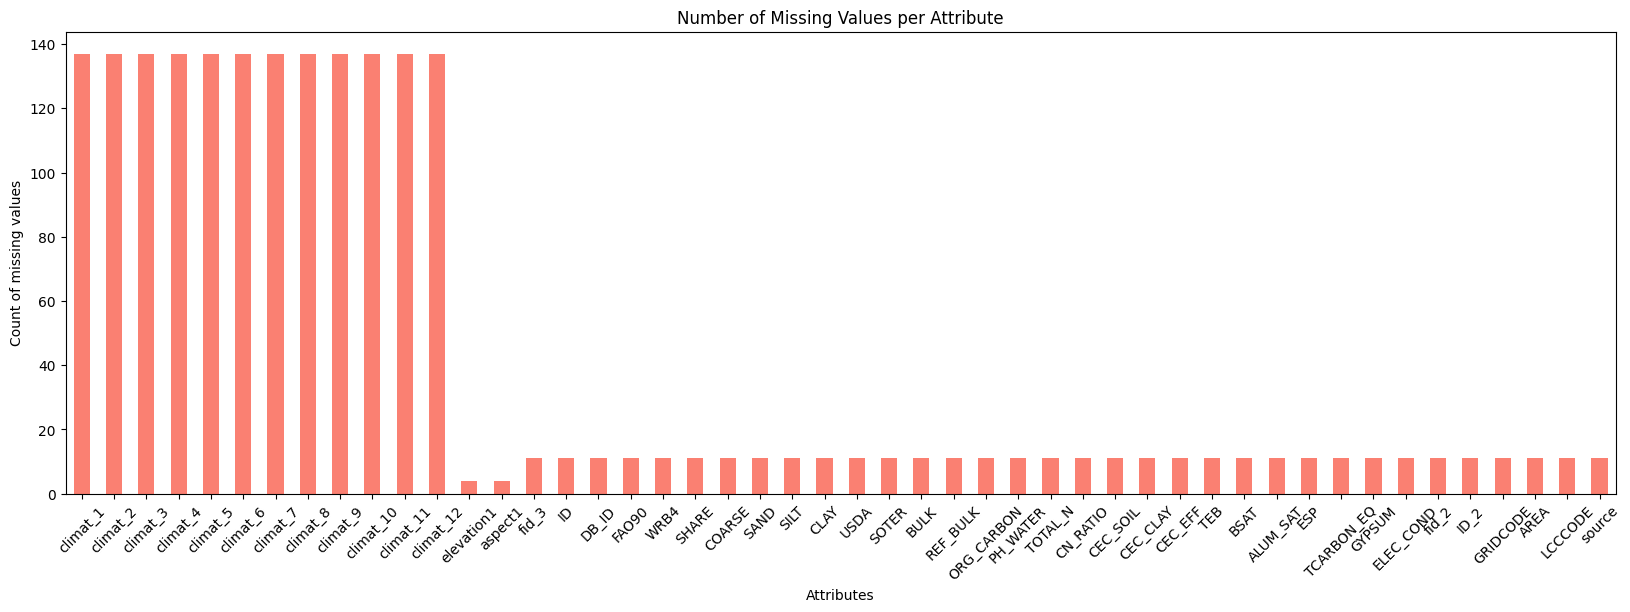

In [ ]:
import matplotlib.pyplot as plt
missing_per_column = gdf.isna().sum()
missing_per_column = missing_per_column[missing_per_column > 0]  # only columns with missing values

plt.figure(figsize=(20,6))
missing_per_column.plot(kind='bar', color='salmon')
plt.title("Number of Missing Values per Attribute")
plt.ylabel("Count of missing values")
plt.xlabel("Attributes")
plt.xticks(rotation=45)
plt.show()


In [ ]:
output_path = "/content/drive/MyDrive/data_set/merge/clean/no missing values/data_set_fire_clean.gpkg"
# --- Remove rows with missing values ---
gdf_clean = gdf.dropna()

# Number of removed rows
removed = len(gdf) - len(gdf_clean)
print("Number of removed rows:", removed)

# --- Save cleaned dataset ---
gdf_clean.to_file(output_path, driver="GPKG")

print("Cleaned file saved to:", output_path)

Number of removed rows: 148
Cleaned file saved to: /content/drive/MyDrive/data_set/merge/clean/no missing values/data_set_fire_clean.gpkg


# Soil

## Non soil

In [ ]:
path = "/content/drive/MyDrive/data_set/merge/clean/transformation climat/data_set_fire_perc_log10.gpkg"
gdf = gpd.read_file(path)


# Convert CLAY to numeric
gdf["CLAY"] = pd.to_numeric(gdf["CLAY"], errors="coerce")

# Filter rows with negative CLAY
neg_clay_rows = gdf[gdf["CLAY"] < 0]

# Group by CLAY, FAO90, and fire status, count rows
counts_fire = (
    neg_clay_rows.groupby(["CLAY", "FAO90", "fire"])
    .size()
    .reset_index(name="row_count")
)

# Display
print(counts_fire.sort_values(["CLAY", "FAO90", "fire"]))

   CLAY FAO90   fire  row_count
0  -9.0    UR  False         61
1  -9.0    UR   True        156
2  -1.0    WR  False         14


## Outliers

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from matplotlib.patches import Patch

# --- Load shapefile ---
shapefile_path = "/content/drive/MyDrive/data_set/merge/clean/transformation climat/data_set_fire_perc_log10.gpkg"
gdf = gpd.read_file(shapefile_path)
neg_count = (gdf["CLAY"] < 0).sum()
print("Number of rows with negative CLAY values (removed):", neg_count)
gdf_soil = gdf[gdf["CLAY"] >= 0].copy()
print("Number of rows after removing negatives:", len(gdf_soil))
# --- Columns to INCLUDE (ignore numbers) ---
cols_to_plot = [
    "COARSE",
    "SAND",
    "SILT",
    "CLAY",
    "BULK",
    "REF_BULK",
    "ORG_CARBON",
    "PH_WATER",
    "TOTAL_N",
    "CN_RATIO",
    "CEC_SOIL",
    "CEC_CLAY",
    "CEC_EFF",
    "TEB",
    "BSAT",
    "ALUM_SAT",
    "ESP",
    "TCARBON_EQ",
    "GYPSUM",
    "ELEC_COND",
]



# --- Function: classify outliers ---
def classify_outliers(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.notna().sum() == 0:
        return np.full(len(series), 'lightgrey', dtype=object), False

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    small_outliers = (series < lower)
    big_outliers = series > upper

    color = np.full(len(series), 'lightgrey', dtype=object)
    color[small_outliers] = 'orange'
    color[big_outliers] = 'red'

    has_outliers = small_outliers.any() or big_outliers.any()
    return color, has_outliers

# --- Determine which columns have outliers ---
cols_with_outliers = []
color_maps = {}
for col in cols_to_plot:
    colors, has_outliers = classify_outliers(gdf_soil[col])
    if has_outliers:
        cols_with_outliers.append(col)
        color_maps[col] = colors

print(f"\nColumns with outliers ({len(cols_with_outliers)}):", cols_with_outliers)

# --- Plot setup ---
n_cols = 2
n_rows = ceil(len(cols_with_outliers) / n_cols)

# Make figure taller and maps take much more space (1:5 ratio)
fig = plt.figure(figsize=(16, 10 * n_rows))
gs = fig.add_gridspec(n_rows * 2, n_cols, height_ratios=[1, 5] * n_rows)

# --- Plot each variable ---
for i, col in enumerate(cols_with_outliers):
    row = i // n_cols
    col_pos = i % n_cols

    # Small top boxplot
    ax_box = fig.add_subplot(gs[row * 2, col_pos])
    data = pd.to_numeric(gdf_soil[col], errors='coerce').dropna()
    ax_box.boxplot(data, vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='black'),
                   medianprops=dict(color='red'))
    ax_box.set_title(f"{col} Distribution", fontsize=11)
    ax_box.set_yticks([])
    ax_box.tick_params(axis='x', labelsize=9)
    ax_box.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Larger bottom map
    ax_map = fig.add_subplot(gs[row * 2 + 1, col_pos])
    gdf_soil.plot(ax=ax_map, color=color_maps[col], edgecolor='black', linewidth=0.1)
    ax_map.set_title(f"{col} Outliers", fontsize=11)
    ax_map.axis('off')

# Remove unused cells (in case odd number of columns)
for j in range(len(cols_with_outliers), n_rows * n_cols):
    fig.delaxes(fig.add_subplot(gs[(j // n_cols) * 2 + 1, j % n_cols]))

# --- Legend ---
legend_elements = [
    Patch(facecolor='lightgrey', edgecolor='black', label='Normal'),
    Patch(facecolor='orange', edgecolor='black', label='Small outlier (≥0)'),
    Patch(facecolor='red', edgecolor='black', label='Big outlier')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### transformation

In [ ]:
cols_log = ["CEC_EFF", "ALUM_SAT", "ESP", "GYPSUM", "ELEC_COND", "TEB","BSAT"]
# Create mask for strictly positive values
mask = gdf_soil[col] > 0

# Apply log10 only where mask is True
gdf_soil.loc[mask, col] = np.log10(gdf_soil.loc[mask, col])


In [ ]:


neg_count = (gdf_soil["CLAY"] < 0).sum()
print("Number of rows with negative CLAY values (removed):", neg_count)
gdf_soil = gdf_soil[gdf_soil["CLAY"] >= 0].copy()
print("Number of rows after removing negatives:", len(gdf_soil))
# --- Columns to INCLUDE (ignore numbers) ---
cols_to_plot = [
    "COARSE",
    "SAND",
    "SILT",
    "CLAY",
    "BULK",
    "REF_BULK",
    "ORG_CARBON",
    "PH_WATER",
    "TOTAL_N",
    "CN_RATIO",
    "CEC_SOIL",
    "CEC_CLAY",
    "CEC_EFF",
    "TEB",
    "BSAT",
    "ALUM_SAT",
    "ESP",
    "TCARBON_EQ",
    "GYPSUM",
    "ELEC_COND",
]



# --- Function: classify outliers ---
def classify_outliers(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.notna().sum() == 0:
        return np.full(len(series), 'lightgrey', dtype=object), False

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    small_outliers = (series < lower)
    big_outliers = series > upper

    color = np.full(len(series), 'lightgrey', dtype=object)
    color[small_outliers] = 'orange'
    color[big_outliers] = 'red'

    has_outliers = small_outliers.any() or big_outliers.any()
    return color, has_outliers

# --- Determine which columns have outliers ---
cols_with_outliers = []
color_maps = {}
for col in cols_to_plot:
    colors, has_outliers = classify_outliers(gdf_soil[col])
    if has_outliers:
        cols_with_outliers.append(col)
        color_maps[col] = colors

print(f"\nColumns with outliers ({len(cols_with_outliers)}):", cols_with_outliers)

# --- Plot setup ---
n_cols = 2
n_rows = ceil(len(cols_with_outliers) / n_cols)

# Make figure taller and maps take much more space (1:5 ratio)
fig = plt.figure(figsize=(16, 10 * n_rows))
gs = fig.add_gridspec(n_rows * 2, n_cols, height_ratios=[1, 5] * n_rows)

# --- Plot each variable ---
for i, col in enumerate(cols_with_outliers):
    row = i // n_cols
    col_pos = i % n_cols

    # Small top boxplot
    ax_box = fig.add_subplot(gs[row * 2, col_pos])
    data = pd.to_numeric(gdf_soil[col], errors='coerce').dropna()
    ax_box.boxplot(data, vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='black'),
                   medianprops=dict(color='red'))
    ax_box.set_title(f"{col} Distribution", fontsize=11)
    ax_box.set_yticks([])
    ax_box.tick_params(axis='x', labelsize=9)
    ax_box.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Larger bottom map
    ax_map = fig.add_subplot(gs[row * 2 + 1, col_pos])
    gdf_soil.plot(ax=ax_map, color=color_maps[col], edgecolor='black', linewidth=0.1)
    ax_map.set_title(f"{col} Outliers", fontsize=11)
    ax_map.axis('off')

# Remove unused cells (in case odd number of columns)
for j in range(len(cols_with_outliers), n_rows * n_cols):
    fig.delaxes(fig.add_subplot(gs[(j // n_cols) * 2 + 1, j % n_cols]))

# --- Legend ---
legend_elements = [
    Patch(facecolor='lightgrey', edgecolor='black', label='Normal'),
    Patch(facecolor='orange', edgecolor='black', label='Small outlier (≥0)'),
    Patch(facecolor='red', edgecolor='black', label='Big outlier')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### fix negative values

In [ ]:
import geopandas as gpd
import pandas as pd

# Load your main gdf
shapefile_path = "/content/drive/MyDrive/data_set/merge/clean/transformation climat/data_set_fire_perc_log10.gpkg"
gdf = gpd.read_file(shapefile_path)

# Load your soil dataframe (you already have this)
# Example:
# gdf_soil = gpd.read_file("/content/.../gdf_soil.gpkg")

# --- 1. Find rows where CLAY < 0 ---
negative_clay = gdf[gdf["CLAY"] < 0]

print("Rows where CLAY < 0:", len(negative_clay))
print("Total rows in gdf:", len(gdf))

# --- 2. Concatenate with gdf_soil ---
gdf_soil = pd.concat([gdf_soil, negative_clay], ignore_index=True)

print("New length of gdf_soil:", len(gdf_soil))


Rows where CLAY < 0: 231
Total rows in gdf: 12248
New length of gdf_soil: 12248


In [ ]:
# Convert all numeric columns to numeric (safe)
gdf_soil_num = gdf_soil.apply(pd.to_numeric, errors="ignore")

print("\n--- Columns with negative values in gdf_soil ---")

for col in gdf_soil_num.columns:
    # Only check numeric columns
    if pd.api.types.is_numeric_dtype(gdf_soil_num[col]):
        neg_mask = gdf_soil_num[col] < 0
        count_neg = neg_mask.sum()

        if count_neg > 0:
            print(f"{col}: {count_neg} rows")



--- Columns with negative values in gdf_soil ---
tmin_s1: 2 rows
ndvi1: 27 rows
elevation1: 133 rows
aspect1: 138 rows
COARSE: 231 rows
SAND: 231 rows
SILT: 231 rows
CLAY: 231 rows
BULK: 231 rows
REF_BULK: 231 rows
ORG_CARBON: 231 rows
PH_WATER: 231 rows
TOTAL_N: 231 rows
CN_RATIO: 231 rows
CEC_SOIL: 231 rows
CEC_CLAY: 231 rows
CEC_EFF: 231 rows
TEB: 231 rows
BSAT: 231 rows
ALUM_SAT: 231 rows
ESP: 231 rows
TCARBON_EQ: 231 rows
GYPSUM: 231 rows
ELEC_COND: 231 rows


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1991: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  result = super().apply(


In [ ]:
cols = [
    "COARSE", "SAND", "SILT", "CLAY", "BULK", "REF_BULK", "ORG_CARBON",
    "PH_WATER", "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF",
    "TEB", "BSAT", "ALUM_SAT", "ESP", "TCARBON_EQ", "GYPSUM", "ELEC_COND"
]
for col in cols:
    gdf_soil[col] = pd.to_numeric(gdf_soil[col], errors="coerce")
    gdf_soil.loc[gdf_soil[col] == -9, col] = -2
count_minus1 = (gdf_soil["CLAY"] == -1).sum()
count_minus2 = (gdf_soil["CLAY"] == -2).sum()

print("Number of rows where CLAY = -1:", count_minus1)
print("Number of rows where CLAY = -2:", count_minus2)


Number of rows where CLAY = -1: 14
Number of rows where CLAY = -2: 217


In [ ]:
output_path = "/content/drive/MyDrive/data_set/merge/clean/transformation final/final_data_set_fire.gpkg"

gdf_soil.to_file(output_path, driver="GPKG")
print("Saved:", output_path)


Saved: /content/drive/MyDrive/data_set/merge/clean/transformation final/final_data_set_fire.gpkg
